# Newtrinos.jl

**Newtrinos.jl** is a Julia package for the **global analysis of neutrino data**.

## Overview

The package is built to support flexible and modular analysis of neutrino physics, combining experimental data with physics models and inference tools.

## Code Structure

Newtrinos.jl is organized into three core components:

- **Experimental Likelihoods** (`src/experiments`):  
  Modules for various neutrino experiments and datasets, each encapsulating experiment-specific behavior.

- **Physics Modules** (`src/physics`):  
  Functions and tools for computing physics, such as neutrino oscillation probabilities, atmospheric fluxes, and other theoretical predictions.

- **Analysis Tools** (`src/analysis`):  
  Interfaces for running inference — both **Frequentist** and **Bayesian** — using experimental and theoretical models.

## Design Philosophy

The codebase follows a **modular** and **orthogonal** architecture:

- **Experiments** only depend on their specific setup and data; they do **not** contain any theory or inference logic.
- **Physics** modules focus solely on theoretical modeling; they are unaware of experiments or statistical methods.
- **Inference** tools treat experiments and theory modules as interchangeable black boxes — allowing flexible composition.

This separation is enforced through consistent interfaces and data structures.

## Module Conventions

To ensure interoperability, each module (experimental or theoretical) should follow these conventions:

- Physics Modules should upon configuration return a struct of abstract type Newtrinos.Physics that contains at least the follwoing:
```julia
params::NamedTuple     # Nominal values of the parameters concerning the module
priors::NamedTuple     # Priors (Distributions) for the parameters of the module
```
And in addition provided some functionality to be used by experiments, for instance some functions.
  
- Experiments should return a struct of abstract type Newtrinos.Experiment that contains the follwoing:
```julia
physics::NamedTuple     # The configured physics module structs for that module
params::NamedTuple      # Nominal values of the parameters concerning the module
priors::NamedTuple      # Priors (Distributions) for the parameters of the module
assets::NamedTuple      # all (meta)data the module needs, such as MC and other data.
                        # This NamedTuple is also expected to have a field `observed` that contains the observed data
forward_model::Function # A callable model for likelihood evaluation
plot::Function          # (Optional) Visualize data or model output
```

## Example Lieklihood

This section shows an example how to set up a joint likelihood.

In [1]:
using Newtrinos

[ Info: Precompiling Newtrinos [5b289081-bab5-45e8-97fc-86872f1653a0] (cache misses: include_dependency fsize change (4), incompatible header (12))
[ Info: Setting new default BAT context BATContext{Float64}(Random123.Philox4x{UInt64, 10}(0xec5d09e380f8d1cb, 0x84aff4ac5d843822, 0xa89e9a1c2d97a0ce, 0x2a9465260bf7b458, 0x9166e89759609cf3, 0x60bbb07bbe9fdd87, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0), HeterogeneousComputing.CPUnit(), BAT._NoADSelected())


We need to specify the physics we want to use.
Here we decided on a module for standard 3-flavour oscillations with basic propagation, all states used for oscillations, and standard interactions (matter effects).
Furthermore we use modules for computing atmospheric fluxes and Earth density profiles (each just with standard configuration here)

In [2]:
osc_cfg = Newtrinos.osc.OscillationConfig(
    flavour=Newtrinos.osc.ThreeFlavour(),
    propagation=Newtrinos.osc.Basic(),
    states=Newtrinos.osc.All(),
    interaction=Newtrinos.osc.SI()
    )

osc = Newtrinos.osc.configure(osc_cfg)
atm_flux = Newtrinos.atm_flux.configure()
earth_layers = Newtrinos.earth_layers.configure()

physics = (; osc, atm_flux, earth_layers);

Here we choose four experimental likelihoods. The experimental likelihoods need to be configured with the physics. here we use the same physics for all modules, and each module grabs whatever it needs.

In [4]:
experiments = (
    deepcore = Newtrinos.deepcore.configure(physics),
    dayabay = Newtrinos.dayabay.configure(physics),
    kamland = Newtrinos.kamland.configure(physics),
    minos = Newtrinos.minos.configure(physics)
);

[ Info: Loading deepcore data
[ Info: Loading dayabay data
[ Info: Loading kamland data
[ Info: Loading minos data


This is enough to generate a joint likelihood for everything:

In [5]:
likelihood = Newtrinos.generate_likelihood(experiments);

Let's evaluate the likelihood! For this we also need parameter values. The following function goes through both. all experimts and all their theory modules and collects all parameters:

In [6]:
p = Newtrinos.get_params(experiments)

(atm_flux_delta_spectral_index = 0.0, atm_flux_nuenumu_sigma = 0.0, atm_flux_nunubar_sigma = 0.0, atm_flux_uphorizonzal_sigma = 0.0, deepcore_atm_muon_scale = 1.0, deepcore_ice_absorption = 1.0, deepcore_ice_scattering = 1.0, deepcore_lifetime = 2.5, deepcore_opt_eff_headon = 0.0, deepcore_opt_eff_lateral = 0.0, deepcore_opt_eff_overall = 1.0, kamland_energy_scale = 0.0, kamland_flux_scale = 0.0, kamland_geonu_scale = 0.0, nc_norm = 1.0, nutau_cc_norm = 1.0, Δm²₂₁ = 7.53e-5, Δm²₃₁ = 0.0024752999999999997, δCP = 1.0, θ₁₂ = 0.5872523687443223, θ₁₃ = 0.1454258194533693, θ₂₃ = 0.8556288707523761)

In [7]:
using DensityInterface

In [18]:
@time logdensityof(likelihood, p)

  0.036591 seconds (49.15 k allocations: 88.214 MiB)


-1080.948711430584

If the experiment provides a plotting function, we can make convenient plots:

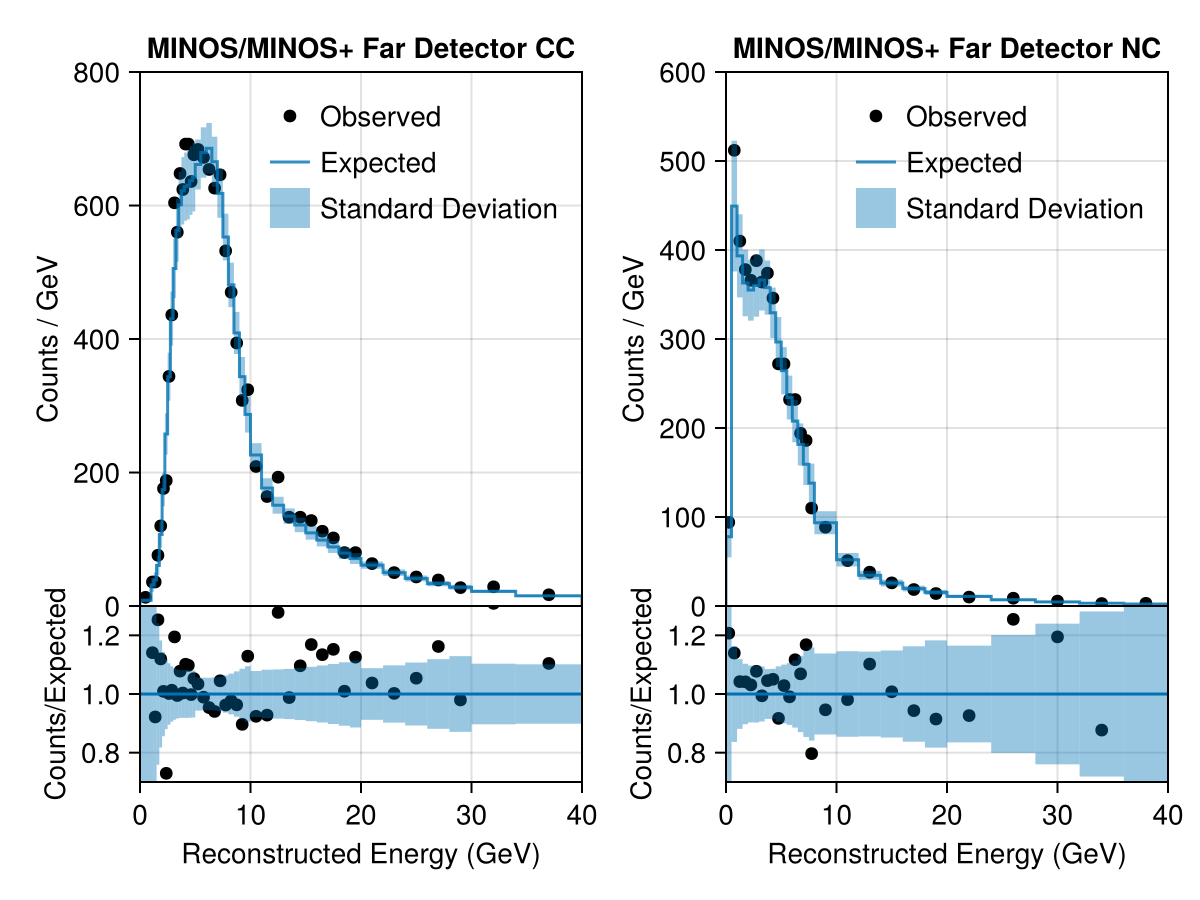

In [9]:
img = experiments.minos.plot(p)
display("image/png", img)

## Automatic Differentiation

For efficient inference, it is important to have access to gradients. therefore all code is fully differentiable via auto-diff, using the ForwardDiff package:

In [10]:
using ForwardDiff

In [11]:
f(p) = logdensityof(likelihood, p)

f (generic function with 1 method)

In [21]:
@time ForwardDiff.gradient(f, p)

  0.956603 seconds (131.45 k allocations: 1.702 GiB, 33.27% gc time)


(atm_flux_delta_spectral_index = 277.29086466359576, atm_flux_nuenumu_sigma = -0.6422706076478163, atm_flux_nunubar_sigma = -3.9275594358666766, atm_flux_uphorizonzal_sigma = 1.4641078777154866, deepcore_atm_muon_scale = -1.5541399849104751, deepcore_ice_absorption = 21.901250674708564, deepcore_ice_scattering = 317.00690255688323, deepcore_lifetime = -198.82833941678714, deepcore_opt_eff_headon = -34.21850176709792, deepcore_opt_eff_lateral = 40.712265251082904, deepcore_opt_eff_overall = -273.6626849692175, kamland_energy_scale = -1.3322233658320863, kamland_flux_scale = 1.1102273782788554, kamland_geonu_scale = 1.3338116809640645, nc_norm = -27.31009253496517, nutau_cc_norm = -60.40087334733048, Δm²₂₁ = 683312.4935157043, Δm²₃₁ = 14938.517101540385, δCP = -0.536530329973077, θ₁₂ = -19.316379984857633, θ₁₃ = 420.05036198958305, θ₂₃ = -173.51048034602746)

## Inference

Let's run a likelihood analysis to construct confidence contours in the (θ₂₃, Δm²₃₁) parameter space.
Here we use a conditional likelihood for illusatration. More realistically, you may want to run `Newtrinos.profile` instead for a full profile likelihood.
Examples on Bayesian Inference will follow.

In [13]:
result = Newtrinos.scan(likelihood, Newtrinos.get_priors(experiments), (θ₂₃=31, Δm²₃₁=31), p)

NewtrinosResult((θ₂₃ = [0.5235987755982988, 0.5410520681182421, 0.5585053606381853, 0.5759586531581287, 0.593411945678072, 0.6108652381980153, 0.6283185307179586, 0.6457718232379018, 0.6632251157578452, 0.6806784082777885  …  0.890117918517108, 0.9075712110370513, 0.9250245035569946, 0.9424777960769379, 0.9599310885968813, 0.9773843811168245, 0.9948376736367678, 1.012290966156711, 1.0297442586766543, 1.0471975511965976], Δm²₃₁ = [0.002, 0.002033333333333333, 0.0020666666666666667, 0.0021, 0.0021333333333333334, 0.0021666666666666666, 0.0022, 0.0022333333333333333, 0.002266666666666667, 0.0023  …  0.0027, 0.0027333333333333333, 0.002766666666666667, 0.0028, 0.0028333333333333335, 0.0028666666666666667, 0.0029000000000000002, 0.0029333333333333334, 0.002966666666666667, 0.003]), (atm_flux_delta_spectral_index = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], atm_flux_nuenumu_sigma = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 

In [14]:
using CairoMakie

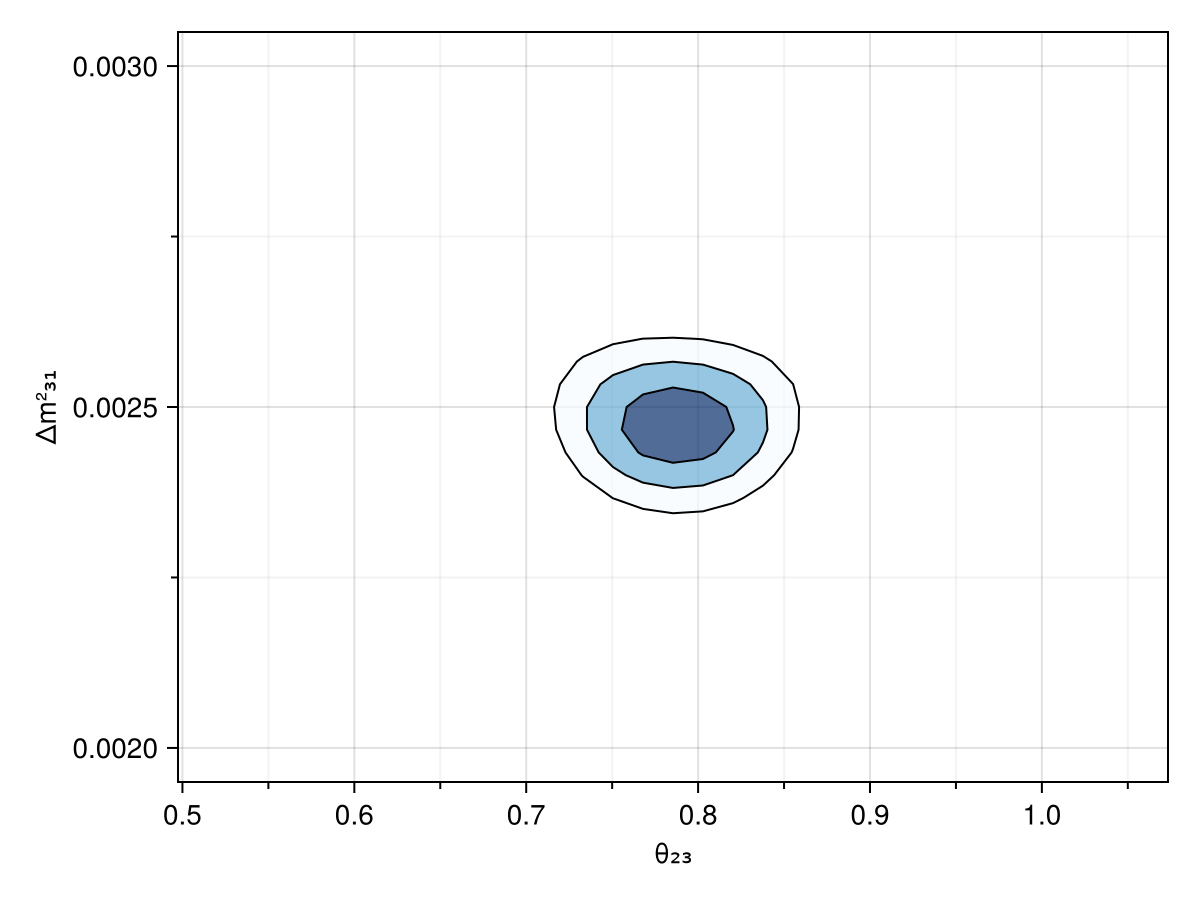

In [15]:
img = plot(result)
display("image/png", img)